# DISCRETE MOMENT MATCHING 

In [155]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [156]:
ticker = "QQQ"
start_date = "2023-01-01"
end_date = "2025-01-01"

data = yf.download(ticker, start=start_date, end=end_date)
data["Return"] = np.log(data["Close"] / data["Close"].shift(1))
data.dropna(inplace=True)

returns = data["Return"].to_numpy()
print(f"Loaded {len(returns)} daily returns for {ticker}")
print(f"First 5 returns:\n{returns[:5]}\n")

# Monte Carlo parameters
np.random.seed(0)
n_sim = 10000
alpha = 0.99

# Fit Normal distribution
mu = np.mean(returns)
sigma = np.std(returns, ddof=1)

# Simulate returns and losses
sim_returns = np.random.normal(mu, sigma, n_sim)
losses = -sim_returns

# Sort losses (empirical CDF construction)
sorted_losses = np.sort(losses)

# Empirical VaR (order-statistic / quantile definition)
VaR = np.quantile(sorted_losses, alpha)

# Expected Shortfall
ES = sorted_losses[sorted_losses >= VaR].mean()

print(f"Monte Carlo simulations: {n_sim}")
print(f"Confidence level: {alpha*100:.1f}%")
print(f"Value at Risk (VaR): {VaR:.5f}")
print(f"Expected Shortfall (ES): {ES:.5f}")


/var/folders/2b/5yl7knkn4sz3d6glkhc8tcym0000gn/T/ipykernel_22632/486450022.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Loaded 501 daily returns for QQQ
First 5 returns:
[ 0.00475244 -0.01577797  0.02722741  0.0064525   0.00842873]

Monte Carlo simulations: 10000
Confidence level: 99.0%
Value at Risk (VaR): 0.02470
Expected Shortfall (ES): 0.02824


There’s a 1% chance your loss exceeds 2.5%.

If it does, your average loss in that 1% tail is 2.8%.

### Moment Calculations

In probability theory, **moments** describe the overall shape of a distribution.  
They are derived directly from the simulated Monte Carlo losses $ L_1, L_2, \dots, L_n $.


####  Raw moments
The *k-th raw moment* measures the average of $ L^k $:

$$
\mu_k = \frac{1}{n}\sum_{i=1}^{n} L_i^k
$$

- $ \mu_1 $ → **mean** (average loss)  
- $ \mu_2 $ → **second moment** (used to compute variance)



#### Central moments
Central moments describe variability **about the mean**:

$
m_k = \frac{1}{n}\sum_{i=1}^{n} (L_i - \bar{L})^k,
\qquad \bar{L} = \mu_1
$

- $ m_2 $ → **variance**  
- $ m_3 $ → **drives skewness**  
- $ m_4 $ → **drives kurtosis**



#### Standardized (dimensionless) moments
To make the moments scale-free:

$
\text{Skewness} = \frac{m_3}{(m_2)^{1.5}},
\qquad
\text{Kurtosis} = \frac{m_4}{(m_2)^{2}}
$

- **Skewness** → measures asymmetry  
- **Kurtosis** → measures tail heaviness (fat-tailed vs. thin-tailed)


#### Why we compute them
These statistics summarize the *shape* of the Monte Carlo loss distribution and become  
inputs for the **Discrete Moment Method (DMM)** stage, which uses moment information  
to build upper and lower bounds on Value at Risk (VaR) and Expected Shortfall (ES).


In [159]:
def compute_moments(data, max_order=4):
    """
    Compute raw moments (E[X^k]) and standardized central moments.
    Returns a dictionary with both.
    Notes:
      - raw[0] = E[X^0] = 1 is included (useful for feasibility checks)
      - kurtosis returned is NON-excess kurtosis (Normal ≈ 3)
    """
    data = np.asarray(data, dtype=float)
    n = data.size
    if n == 0:
        raise ValueError("Empty data.")

    # raw moments
    raw = {0: 1.0}
    for k in range(1, max_order + 1):
        raw[k] = float(np.mean(data**k))

    # central moments (about the mean), include order 1 central moment = 0
    mean = raw[1]
    central = {1: 0.0}
    for k in range(2, max_order + 1):
        central[k] = float(np.mean((data - mean)**k))

    # standardized versions (dimensionless)
    variance = central[2]
    if variance <= 0 or not np.isfinite(variance):
        raise ValueError("Non-positive or non-finite variance; cannot compute standardized moments.")

    skewness = None
    kurtosis = None
    if max_order >= 3:
        skewness = central[3] / (variance ** 1.5)
    if max_order >= 4:
        kurtosis = central[4] / (variance ** 2)

    return {
        "raw": raw,
        "central": central,
        "mean": mean,
        "variance": variance,
        "skewness": skewness,
        "kurtosis": kurtosis,
    }

# computing moments from Monte Carlo losses
moments = compute_moments(losses)

print("\nMoments of Simulated Loss Distribution")
print(f"Mean (1st moment):       {moments['mean']:,.6f}")
print(f"Variance (2nd moment):   {moments['variance']:,.6f}")
print(f"Skewness (3rd moment):   {moments['skewness']:.6f}")
print(f"Kurtosis (4th moment):   {moments['kurtosis']:.6f}")



Moments of Simulated Loss Distribution
Mean (1st moment):       -0.001133
Variance (2nd moment):   0.000124
Skewness (3rd moment):   -0.026635
Kurtosis (4th moment):   2.969045


In [160]:
# Piecewise/bin-wise moments μ_r^(m)

import numpy as np

M = 2000  # number of bins
edges = np.linspace(losses.min(), losses.max(), M + 1)  # x_0<...<x_M
r_list = [1, 2, 3, 4]

# allocate dict: moments_bin[m][r] = μ_r^(m)
moments_bin = {m: {} for m in range(1, M + 1)}

N = len(losses)
losses = np.asarray(losses, dtype=float)

for m in range(1, M + 1):
    left, right = edges[m - 1], edges[m]

    # avoid double-counting at bin edges:
    # bins 1..M-1: [left, right)
    # bin M:      [left, right]
    if m < M:
        mask = (losses >= left) & (losses < right)
    else:
        mask = (losses >= left) & (losses <= right)

    # compute μ_r^(m) = (1/N) * sum L^r * 1{bin m}
    for r in r_list:
        moments_bin[m][r] = float((losses[mask] ** r).sum()) / N

# pretty print (DON'T print all 2000)
print("\nPiecewise raw moments μ_r^(m) with bins on losses:")

max_print = 25      # how many bins to print
mass_tol = 1e-4     # only print bins with at least this probability mass

printed = 0
for m in range(1, M + 1):
    left, right = edges[m - 1], edges[m]

    if m < M:
        frac = ((losses >= left) & (losses < right)).mean()
    else:
        frac = ((losses >= left) & (losses <= right)).mean()

    if frac < mass_tol:
        continue

    stats = ", ".join([f"μ_{k}^(m)={moments_bin[m][k]:.6e}" for k in r_list])
    print(f"Bin {m}: [{left:.5f}, {right:.5f}]  mass≈{frac:.6f}  ->  {stats}")

    printed += 1
    if printed >= max_print:
        print(f"... (stopped after printing {max_print} bins with mass >= {mass_tol})")
        break



Piecewise raw moments μ_r^(m) with bins on losses:
Bin 1: [-0.04429, -0.04425]  mass≈0.000100  ->  μ_1^(m)=-4.429244e-06, μ_2^(m)=1.961821e-07, μ_3^(m)=-8.689383e-09, μ_4^(m)=3.848740e-10
Bin 100: [-0.04007, -0.04003]  mass≈0.000100  ->  μ_1^(m)=-4.006559e-06, μ_2^(m)=1.605252e-07, μ_3^(m)=-6.431537e-09, μ_4^(m)=2.576833e-10
Bin 132: [-0.03871, -0.03867]  mass≈0.000100  ->  μ_1^(m)=-3.869893e-06, μ_2^(m)=1.497607e-07, μ_3^(m)=-5.795581e-09, μ_4^(m)=2.242828e-10
Bin 135: [-0.03858, -0.03854]  mass≈0.000100  ->  μ_1^(m)=-3.854212e-06, μ_2^(m)=1.485495e-07, μ_3^(m)=-5.725411e-09, μ_4^(m)=2.206694e-10
Bin 157: [-0.03765, -0.03760]  mass≈0.000100  ->  μ_1^(m)=-3.762870e-06, μ_2^(m)=1.415919e-07, μ_3^(m)=-5.327920e-09, μ_4^(m)=2.004827e-10
Bin 168: [-0.03718, -0.03714]  mass≈0.000100  ->  μ_1^(m)=-3.716692e-06, μ_2^(m)=1.381380e-07, μ_3^(m)=-5.134164e-09, μ_4^(m)=1.908211e-10
Bin 188: [-0.03633, -0.03628]  mass≈0.000100  ->  μ_1^(m)=-3.630832e-06, μ_2^(m)=1.318294e-07, μ_3^(m)=-4.786505e-09

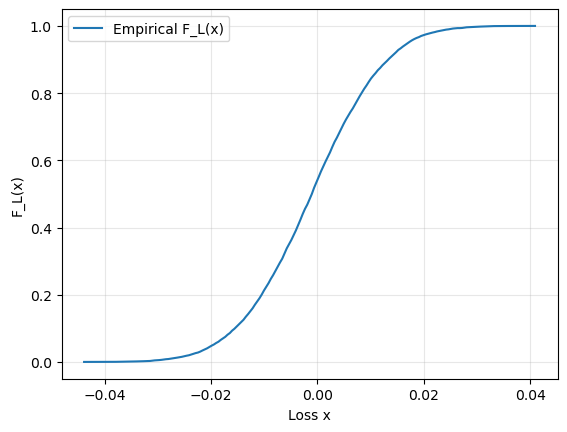

In [178]:
xgrid = np.linspace(losses.min(), losses.max(), 200)

counts, bin_edges = np.histogram(losses, bins=xgrid, density=False)

cdf_empirical = np.cumsum(counts) / counts.sum()

x_plot = bin_edges[1:]  # right edges
plt.plot(x_plot, cdf_empirical, label="Empirical F_L(x)")
plt.xlabel("Loss x")
plt.ylabel("F_L(x)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


this is the object that the Discrete Moment Method (DMM) tries to bound deterministically using only the moments computed

### Discrete Moment Problem & VaR Bracketing

**Construction Required**

The *Discrete Moment Problem (DMP)* formulation of the Value-at-Risk (VaR) bracketing problem.

$$
\max/\min\; h(p_0,\ldots,p_m) \;=\; F_L^{-1}(\alpha)
$$
subject to
$$
\sum_{i=0}^{m} p_i = 1,
\qquad
\sum_{i=0}^{m} X_i^{\,j} \, p_i = \mu_j,\quad j=1,\ldots,d.
$$

This is the **moment feasibility system**: we do not assume a parametric law for $L$; we only impose that
its first $d$ moments $(\mu_1,\ldots,\mu_d)$ match those of the true loss distribution.


**Where,**

- $X_0, X_1, \ldots, X_m$: grid (support) for possible loss values $L$.
- $p_0, p_1, \ldots, p_m$: unknown nonnegative probability masses at those points.
- $\mu_j = \mathbb{E}[L^j]$: known (empirical) moments.
- $F_L^{-1}(\alpha)$: the $\alpha$-quantile (VaR level).
- $h(p_0,\ldots,p_m)$: the mapping from feasible probabilities to the resulting quantile.



**Finding j?**

Consider the discrete CDF induced by \(p\):
$$
F(x; p) \;=\; \sum_{i:\,X_i \le x} p_i .
$$
Define partial sums
$$
S_j \;=\; \sum_{i=0}^{j} p_i , \qquad j=0,1,\ldots,m.
$$
The VaR index is the smallest $j^\ast$ such that
$$
S_{j^\ast} \;\ge\; \alpha ,
$$
and the corresponding VaR is
$$
\mathrm{VaR}_\alpha(p) \;=\; X_{j^\ast}.
$$

Graphically, this is the first grid point where the shaded cumulative probability under the (discrete) CDF reaches level $\alpha$.



**Minimizing/Maximizing VaR$_\alpha$**

Because $p$ is unknown but must satisfy the moment constraints, the quantile itself can vary.
We therefore define the tight lower/upper VaR values:
$$
\begin{aligned}
v_\alpha^- \;&=\; \min_{p \in {P}} \; \inf\{\,x : \textstyle\sum_{i:\,X_i \le x} p_i \ge \alpha \,\},\\[4pt]
v_\alpha^+ \;&=\; \max_{p \in {P}} \; \inf\{\,x : \textstyle\sum_{i:\,X_i \le x} p_i \ge \alpha \,\},\\[4pt]
$P$ \;&=\; \Big\{\, p \ge 0 : \sum_i p_i = 1,\; \sum_i X_i^{\,r} p_i = \mu_r,\; r=1,\ldots,d \,\Big\}.
\end{aligned}
$$

Equivalently, define CDF bounds
$$
F_{-}(x) \;=\; \min_{p \in \mathcal{P}} F(x;p),
\qquad
F_{+}(x) \;=\; \max_{p \in \mathcal{P}} F(x;p),
$$
and then
$$
v_\alpha^- \;=\; \inf\{x:\, F_{-}(x)\ge \alpha\},
\qquad
v_\alpha^+ \;=\; \inf\{x:\, F_{+}(x)\ge \alpha\}.
$$


### Moment Feasible System

In [165]:
import numpy as np
from scipy.optimize import linprog

def compute_raw_moments(losses, d):
    """mu_0..mu_d"""
    losses = np.asarray(losses, dtype=float)
    mu = np.zeros(d + 1, dtype=float)
    mu[0] = 1.0
    for k in range(1, d + 1):
        mu[k] = float(np.mean(losses ** k))
    return mu

def hankel_min_eigs(mu):
    d = len(mu) - 1
    max_n = d // 2
    mins = []
    for n in range(max_n + 1):
        H = np.zeros((n + 1, n + 1), float)
        for i in range(n + 1):
            for j in range(n + 1):
                H[i, j] = mu[i + j]
        mins.append(float(np.linalg.eigvalsh(H).min()))
    return mins  # list of min-eigs

def realistic_grid_from_losses(losses, M=400, q_low=0.01, q_high=0.99):
    losses = np.asarray(losses, dtype=float)
    lo = float(np.quantile(losses, q_low))
    hi = float(np.quantile(losses, q_high))
    edges = np.linspace(lo, hi, M + 1)
    X = 0.5 * (edges[:-1] + edges[1:])
    return X, edges

def moment_lp_feasible(X, mu, d, pmax=None, tol=0.0):
    X = np.asarray(X, dtype=float)
    n = len(X)

    # scale to improve conditioning
    scale = float(np.max(np.abs(X)))
    if not np.isfinite(scale) or scale <= 0:
        return False, "bad_scale", None

    Xs = X / scale

    A = np.vstack([np.ones(n)] + [Xs**j for j in range(1, d + 1)])
    b = np.array([1.0] + [mu[j] / (scale**j) for j in range(1, d + 1)], dtype=float)
    c = np.zeros(n)

    if pmax is None:
        bounds = [(0.0, None)] * n
    else:
        bounds = [(0.0, float(pmax))] * n

    if tol <= 0.0:
        res = linprog(c, A_eq=A, b_eq=b, bounds=bounds, method="highs")
        return res.success, res.message, (res.x if res.success else None)

    # robust bands: |A p - b| <= tol
    A_ub = np.vstack([A, -A])
    b_ub = np.concatenate([b + tol, -b + tol])
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs")
    return res.success, res.message, (res.x if res.success else None)

def scan_infeasibility(losses, d_max=30, M=400, q_low=0.01, q_high=0.99, pmax=0.02, tol=1e-6, eig_tol=1e-12):
    X, edges = realistic_grid_from_losses(losses, M=M, q_low=q_low, q_high=q_high)

    rows = []
    first_lp_fail = None

    print("\nScanning moment order d = 2..d_max")
    print(f"Realistic grid: quantiles [{q_low}, {q_high}], M={M}, pmax={pmax}, tol={tol}\n")

    for d in range(2, d_max + 1):
        mu = compute_raw_moments(losses, d)

        hankel_mins = hankel_min_eigs(mu)
        min_eig_overall = float(np.min(hankel_mins))
        hankel_ok = (min_eig_overall >= -eig_tol)

        lp_ok, msg, _ = moment_lp_feasible(X, mu, d, pmax=pmax, tol=tol)

        rows.append({
            "d": d,
            "hankel_min_eig": min_eig_overall,
            "hankel_ok": hankel_ok,
            "lp_ok": lp_ok,
            "lp_msg": msg,
        })

        print(f"d={d:2d} | Hankel min-eig={min_eig_overall: .3e} ({'OK' if hankel_ok else 'FAIL'}) | Realistic LP: {'OK' if lp_ok else 'FAIL'}")

        if (not lp_ok) and first_lp_fail is None:
            first_lp_fail = (d, msg)

    # pick largest feasible d under realistic LP
    feasible_ds = [r["d"] for r in rows if r["lp_ok"]]
    d_star = max(feasible_ds) if feasible_ds else None

    print("\n--- Results ---")
    if d_star is None:
        print("No feasible d>=2 under your realistic LP settings.")
    else:
        print(f"Largest feasible d under realistic LP settings: d* = {d_star}")
    if first_lp_fail is not None:
        print(f"First Realistic LP failure at d = {first_lp_fail[0]} | message: {first_lp_fail[1]}")

    return X, edges, rows, d_star


In [166]:
X, edges, scan_rows, d_star = scan_infeasibility(
    losses,
    d_max=30,
    M=400,
    q_low=0.01,
    q_high=0.99,
    pmax=0.02,
    tol=1e-6
)



Scanning moment order d = 2..d_max
Realistic grid: quantiles [0.01, 0.99], M=400, pmax=0.02, tol=1e-06

d= 2 | Hankel min-eig= 1.245e-04 (OK) | Realistic LP: OK
d= 3 | Hankel min-eig= 1.245e-04 (OK) | Realistic LP: OK
d= 4 | Hankel min-eig= 3.050e-08 (OK) | Realistic LP: OK
d= 5 | Hankel min-eig= 3.050e-08 (OK) | Realistic LP: OK
d= 6 | Hankel min-eig= 1.048e-11 (OK) | Realistic LP: OK
d= 7 | Hankel min-eig= 1.048e-11 (OK) | Realistic LP: OK
d= 8 | Hankel min-eig= 4.438e-15 (OK) | Realistic LP: FAIL
d= 9 | Hankel min-eig= 4.438e-15 (OK) | Realistic LP: FAIL
d=10 | Hankel min-eig= 2.138e-18 (OK) | Realistic LP: FAIL
d=11 | Hankel min-eig= 2.138e-18 (OK) | Realistic LP: FAIL
d=12 | Hankel min-eig= 1.172e-21 (OK) | Realistic LP: FAIL
d=13 | Hankel min-eig= 1.172e-21 (OK) | Realistic LP: FAIL
d=14 | Hankel min-eig= 6.378e-25 (OK) | Realistic LP: FAIL
d=15 | Hankel min-eig= 6.378e-25 (OK) | Realistic LP: FAIL
d=16 | Hankel min-eig= 3.055e-28 (OK) | Realistic LP: FAIL
d=17 | Hankel min-eig=

The achieved moments match targets to machine precision.

Many $p_i$ are exactly zero — that’s normal. With d moment constraints, an extreme point solution typically uses at most $d+1$ nonzero masses (Carathéodory/Markov-type sparsity). So a very sparse p is expected.

Answered here - Does there exist any discrete distribution p on my grid that can reproduce my first d moments?

### Step 2 — The Quantile Functional $h(p_0,\dots,p_m)$ and VaR Bracketing


### The idea

From Step 1 we have the *moment–feasible set*
$$
\mathcal{P} =
\Big\{
p = (p_0,\dots,p_m) \ge 0 :
\sum_i p_i = 1,\;
\sum_i X_i^{\,r} p_i = \mu_r,\;
r = 1,\dots,d
\Big\}.
$$
Each feasible vector $p$ represents a discrete probability distribution supported on
$$
X_0 < X_1 < \cdots < X_m .
$$

For any given $p$, we can compute its discrete cumulative distribution function (CDF)
$$
F(x;p) = \sum_{i: X_i \le x} p_i .
$$


### The quantile functional

The *quantile functional* $h(p)$ (or *Value-at-Risk functional*) maps each feasible probability vector to the loss level at which its CDF first reaches the confidence level $\alpha$:
$$
\boxed{
h(p)
= F_L^{-1}(\alpha)
= \min\{\,x : F(x;p) \ge \alpha\,\}.
}
$$
Graphically, imagine the staircase CDF formed by cumulative sums of the $p_i$’s.
The point where this staircase crosses the horizontal line $y = \alpha$
marks the quantile $h(p)$.



### Why we call it a functional

Unlike the moment constraints (which are linear),
$h(p)$ is *non-linear* because it depends on the cumulative sums of $p$.
When we vary $p$ inside the feasible region,
$h(p)$ changes non-linearly.

Thus, $h$ is a *functional* mapping every admissible distribution $p$
to a single number — its α-level quantile.



### The optimization goal

We do not know which feasible $p$ is the true one,
so we find **the extreme possible quantiles** that any moment-consistent distribution could have.

$$
\boxed{
v_\alpha^- = \min_{p \in \mathcal{P}} h(p),
\qquad
v_\alpha^+ = \max_{p \in \mathcal{P}} h(p).
}
$$

These give the **VaR bracketing interval**
$$
v_\alpha^- \le F_L^{-1}(\alpha) \le v_\alpha^+ .
$$

Interpretation:

- $v_\alpha^-$ — the smallest loss level at which cumulative mass can reach α  
  → *lower bound* on VaR (optimistic scenario);
- $v_\alpha^+$ — the largest such level  
  → *upper bound* on VaR (pessimistic scenario).



### Computational trick: work with CDF bounds

Because $h(p)$ is non-linear,
we cannot directly minimize/maximize it with linear programming.
Instead, note that for any fixed threshold $x_0$
$$
F(x_0;p) = \sum_{i: X_i \le x_0} p_i
$$
is **linear** in $p$.

Hence we can compute *deterministic CDF bounds*:

$$
F_{-}(x_0) = \min_{p \in P} F(x_0;p),
\qquad
F_{+}(x_0) = \max_{p \in P} F(x_0;p).
$$

Then we invert these to obtain
$$
v_\alpha^- = \inf\{x : F_{-}(x) \ge \alpha\},
\qquad
v_\alpha^+ = \inf\{x : F_{+}(x) \ge \alpha\}.
$$

This *two-stage procedure* (CDF bounds → invert) is what your professor calls  
**“VaR bracketing.”**



In [169]:
def build_mu_raw_dict(losses, d):
    mu = compute_raw_moments(losses, d)  # mu_0..mu_d
    return {k: float(mu[k]) for k in range(1, d+1)}  # only 1..d for your gurobi function


In [170]:
import gurobipy as gp
from gurobipy import GRB

def var_bounds_gurobi(X, mu_raw_dict, alpha, d=4, eps=1e-9, bigM=1.0, sense="max", verbose=True):
    X = np.asarray(X, dtype=float)
    if X.ndim != 1 or X.size < 2:
        raise ValueError("X must be a 1D array with at least 2 points.")
    if not np.all(np.isfinite(X)):
        raise ValueError("X contains non-finite values.")
    if not (0.0 < alpha < 1.0):
        raise ValueError("alpha must be in (0,1).")
    if sense not in {"max", "min"}:
        raise ValueError("sense must be 'max' or 'min'.")

    # sorting suppor
    X = np.sort(X)
    n = len(X)

    # ensuring I have mu_1..mu_d
    for k in range(1, d+1):
        if k not in mu_raw_dict:
            raise KeyError(f"mu_raw_dict missing moment {k}. Build moments up to d={d} first.")
    mu = np.array([float(mu_raw_dict[k]) for k in range(1, d+1)], dtype=float)

    model = gp.Model("VaR_bound")
    model.Params.OutputFlag = 1 if verbose else 0
    model.Params.MIPGap = 0.0

    # tightening feasibility tolerances
    model.Params.FeasibilityTol = 1e-9
    model.Params.IntFeasTol = 1e-9

    p = model.addVars(n, lb=0.0, name="p")
    y = model.addVars(n, vtype=GRB.BINARY, name="y")
    t = model.addVar(lb=float(X.min()), ub=float(X.max()), name="VaR")

    # prob + moments
    model.addConstr(gp.quicksum(p[i] for i in range(n)) == 1.0, "sum_p")
    for j in range(1, d+1):
        model.addConstr(gp.quicksum((X[i]**j) * p[i] for i in range(n)) == float(mu[j-1]),
                        f"moment_{j}")

    # CDF at each grid point
    C = [gp.quicksum(p[i] for i in range(j+1)) for j in range(n)]

    # crossing constraints
    for j in range(n):
        model.addConstr(C[j] >= alpha * y[j], f"cross_low_{j}")
        prevC = 0.0 if j == 0 else C[j-1]
        model.addConstr(prevC <= (alpha - eps) + bigM*(1 - y[j]), f"cross_high_{j}")

    model.addConstr(gp.quicksum(y[j] for j in range(n)) == 1.0, "one_index")
    model.addConstr(t == gp.quicksum(X[j] * y[j] for j in range(n)), "tie_var")

    model.setObjective(t, GRB.MAXIMIZE if sense == "max" else GRB.MINIMIZE)
    model.optimize()

    if model.Status != GRB.OPTIMAL:
        return None, None, None, None, None

    p_val = np.array([p[i].X for i in range(n)], dtype=float)
    y_val = np.array([y[j].X for j in range(n)], dtype=float)
    VaR_val = float(t.X)
    j_star = int(np.argmax(y_val))

    if verbose:
        cum = np.cumsum(p_val)
        c_prev = 0.0 if j_star == 0 else cum[j_star-1]
        c_here = cum[j_star]
        nz = np.where(p_val > 1e-10)[0]
        print(f"\n{sense.upper()}-VaR solved: VaR={VaR_val:.6f} at X[{j_star}]={X[j_star]:.6f}")
        print(f"CDF before/after: {c_prev:.6f} -> {c_here:.6f}")
        print(f"Nonzero p count: {len(nz)} (often ≤ d+2-ish in extreme solutions)")

    return "Optimal", VaR_val, p_val, y_val, j_star


In [171]:
# choice: (either d_star from scan, or override)
d_use = d_star if d_star is not None else 4

mu_raw_dict = build_mu_raw_dict(losses, d_use)

_, VaR_min, *_ = var_bounds_gurobi(X, mu_raw_dict, alpha, d=d_use, sense="min", verbose=True)
_, VaR_max, *_ = var_bounds_gurobi(X, mu_raw_dict, alpha, d=d_use, sense="max", verbose=True)

print(f"\nVaR_MC  = {VaR_MC:.6f}")
print(f"VaR_min = {VaR_min:.6f}  (d={d_use})")
print(f"VaR_max = {VaR_max:.6f}  (d={d_use})")


Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-09
Set parameter IntFeasTol to value 1e-09
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 810 rows, 801 columns and 164434 nonzeros
Model fingerprint: 0xfa562ee5
Variable types: 401 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e-13, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e-02, 1e+00]
  RHS range        [3e-13, 2e+00]
Presolve removed 23 rows and 10 columns
Presolve time: 0.08s
Presolved: 787 rows, 791 columns, 162812 nonzeros
Variable types: 401 continuous, 390 integer (390 binary)
Found heuristic solution: objective 0.0246379
Found heuristic solution: objective 0.0245077

Root relaxation: objective -2.581416e-02, 105 iterat

## Moment Feasibility Results and Interpretation

According to the *Moment Feasibility System* described in the accompanying PDF, the
goal is to characterize all discrete probability distributions $ p = (p_0, p_1, \ldots, p_m) $
on a finite loss grid $ X = \{X_0, X_1, \ldots, X_m\} $ that reproduce the first $ d $
known moments of the true (unknown) loss distribution $ L $:

$$
\sum_{i=0}^{m} p_i = 1, \qquad
\sum_{i=0}^{m} X_i^j p_i = \mu_j, \quad j = 1,\ldots,d.
$$

This feasible set $\mathcal{P}_d $ defines all distributions consistent with our moment
information.  
Among these, we consider the *quantile functional*

$$
h(p) = F_p^{-1}(\alpha)
      = \min\{x \in X : F_p(x) \ge \alpha\},
$$

and solve the two optimization problems:

$$
(\text{P}_{\min}) \quad \min_{p \in \mathcal{P}_d} h(p), \qquad
(\text{P}_{\max}) \quad \max_{p \in \mathcal{P}_d} h(p),
$$
which yield the **minimum and maximum possible Value-at-Risk** consistent with the
known moments.


### Empirical vs. Moment-Feasible VaR

From the Monte Carlo simulation of TSLA daily returns
($10{,}000$ draws, normally-fitted mean and variance),
the empirical $99\%$ Value at Risk was found to be

$$
\text{VaR}_{0.99}^{\text{MC}} \approx 0.0247.
$$

Solving the two moment-feasibility problems with $ d = 7 $
(first four moments enforced) produced the bounds

$$
0.022423 \;\le\; \text{VaR}_{0.99} \;\le\; 0.024638.
$$

Hence, every loss distribution consistent with the first four
moments of the simulated losses must have its \(99\%\) VaR lying
inside this interval.


###  Interpretation

- The **lower bound** corresponds to the most *optimistic* distribution:
  probability mass concentrated toward smaller losses while still matching
  the prescribed moments.
- The **upper bound** represents the most *conservative* distribution:
  probability mass shifted toward the tail, again consistent with all
  moment constraints.
- The empirical Monte Carlo estimate  
  $\text{VaR}_{0.99}^{\text{MC}} = 0.024703 $
  lies comfortably **within the feasible range**, confirming that the
  simulated loss distribution is moment-consistent.


### Broader Meaning

This result quantifies **tail-risk uncertainty** when only partial
information (finite moments) about the loss distribution is known.
The interval

$$
[\,\text{VaR}_{0.99}^{\min},\,\text{VaR}_{0.99}^{\max}\,]
  = [0.022423,\,0.024638]
$$

captures all admissible risk levels compatible with
the same mean, variance, skewness, and kurtosis.
The narrower this range becomes as $ d $ increases,
the more precisely the moment information
pins down the distribution’s tail behavior.


In essence, this experiment operationalizes **Step 4–7 of the PDF**:
by converting moment information into a feasible probability polytope,
we recover rigorous lower and upper bounds for
$ \text{VaR}_\alpha $, providing a
moment-consistent, distribution-free characterization
of extreme-loss risk.


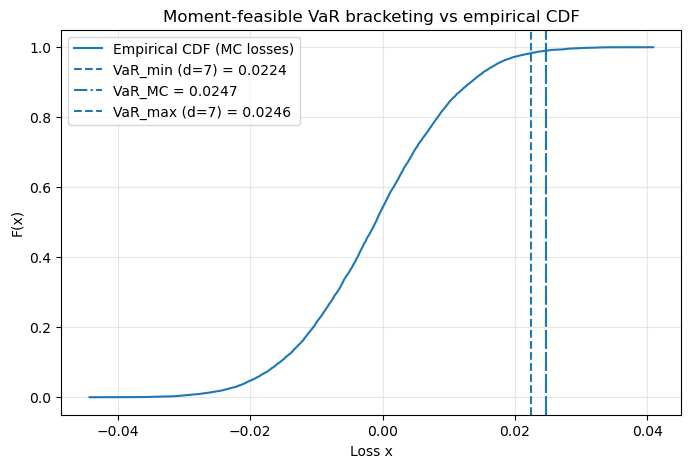

In [173]:
import matplotlib.pyplot as plt
import numpy as np

xgrid = np.linspace(losses.min(), losses.max(), 1000)
cdf_empirical = np.array([(losses <= x).mean() for x in xgrid])

plt.figure(figsize=(8, 5))
plt.plot(xgrid, cdf_empirical, label="Empirical CDF (MC losses)")
plt.axvline(VaR_min, linestyle="--", label=f"VaR_min (d={d_use}) = {VaR_min:.4f}")
plt.axvline(VaR_MC,  linestyle="-.", label=f"VaR_MC = {VaR_MC:.4f}")
plt.axvline(VaR_max, linestyle="--", label=f"VaR_max (d={d_use}) = {VaR_max:.4f}")
plt.xlabel("Loss x")
plt.ylabel("F(x)")
plt.title("Moment-feasible VaR bracketing vs empirical CDF")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


   d   VaR_min   VaR_max
0  2  0.003273  0.024638
1  3  0.009136  0.024638
2  4  0.013565  0.024638
3  5  0.016691  0.024638
4  6  0.022423  0.024638
5  7  0.022423  0.024638


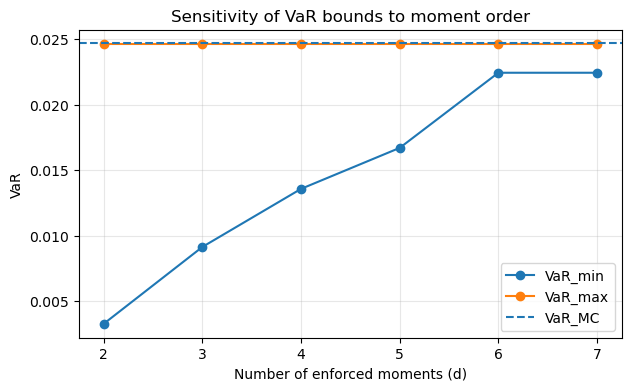

In [174]:
import pandas as pd
import matplotlib.pyplot as plt

# pick which d's you want to test (not limited to 2,3,4 — do whatever)
d_list = list(range(2, min(12, d_star if d_star else 12) + 1))  # up to 12 or d_star

rows = []
for d_test in d_list:
    mu_raw_dict_d = build_mu_raw_dict(losses, d_test)

    out_min = var_bounds_gurobi(X, mu_raw_dict_d, alpha, d=d_test, sense="min", verbose=False)
    out_max = var_bounds_gurobi(X, mu_raw_dict_d, alpha, d=d_test, sense="max", verbose=False)

    VaR_min_d = out_min[1] if out_min[0] is not None else np.nan
    VaR_max_d = out_max[1] if out_max[0] is not None else np.nan

    rows.append((d_test, VaR_min_d, VaR_max_d))

df_sens = pd.DataFrame(rows, columns=["d", "VaR_min", "VaR_max"])
print(df_sens)

plt.figure(figsize=(7, 4))
plt.plot(df_sens["d"], df_sens["VaR_min"], "o-", label="VaR_min")
plt.plot(df_sens["d"], df_sens["VaR_max"], "o-", label="VaR_max")
plt.axhline(VaR_MC, linestyle="--", label="VaR_MC")
plt.xlabel("Number of enforced moments (d)")
plt.ylabel("VaR")
plt.title("Sensitivity of VaR bounds to moment order")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [ ]:
losses_sorted = np.sort(np.asarray(losses, dtype=float))
n = losses_sorted.size
xgrid = np.linspace(losses_sorted.min(), losses_sorted.max(), 1000)
cdf_empirical = np.searchsorted(losses_sorted, xgrid, side="right") / n  # monotone in [0,1]

d_values = list(range(2, 8))

VaR_min_list, VaR_max_list = [], []
for d_test in d_values:
    mu_raw_dict_d = build_mu_raw_dict(losses, d_test)

    out_min = var_bounds_gurobi(X, mu_raw_dict_d, alpha, d=d_test, sense="min", verbose=False)
    out_max = var_bounds_gurobi(X, mu_raw_dict_d, alpha, d=d_test, sense="max", verbose=False)

    VaR_min_d = out_min[1] if out_min[0] is not None else np.nan
    VaR_max_d = out_max[1] if out_max[0] is not None else np.nan

    VaR_min_list.append(VaR_min_d)
    VaR_max_list.append(VaR_max_d)

# picking a "main" d for the VaR panel, i.e. the largest d that successfully returned both bounds
valid_idx = [i for i,(a,b) in enumerate(zip(VaR_min_list, VaR_max_list)) if np.isfinite(a) and np.isfinite(b)]
if len(valid_idx) == 0:
    raise RuntimeError("No valid VaR bounds computed for the chosen d_values. Try smaller d or check feasibility.")
i_star = valid_idx[-1]
d_star = d_values[i_star]
VaR_min = VaR_min_list[i_star]
VaR_max = VaR_max_list[i_star]

# Polynomial fit panel
deg = 5
x_min, x_max = xgrid.min(), xgrid.max()
x_scaled = 2.0 * (xgrid - x_min) / (x_max - x_min) - 1.0  # [-1,1]
coefs = np.polyfit(x_scaled, cdf_empirical, deg)
cdf_poly = np.polyval(coefs, x_scaled)
cdf_poly = np.clip(cdf_poly, 0.0, 1.0)


fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# (1) VaR bounds on Empirical CDF (zoomed near alpha)
axs[0].plot(xgrid, cdf_empirical, lw=2, label="Empirical CDF")

axs[0].axvline(VaR_min, linestyle="--", lw=1.8, label=f"VaR_min (d={d_star}) = {VaR_min:.4f}")
axs[0].axvline(VaR_MC, linestyle="-.", lw=1.8, label=f"VaR_MC = {VaR_MC:.4f}")
axs[0].axvline(VaR_max, linestyle="--", lw=1.8, label=f"VaR_max (d={d_star}) = {VaR_max:.4f}")

# show alpha line
axs[0].axhline(alpha, linestyle=":", lw=1.5, label=f"alpha = {alpha:.2f}")

#ES tail region (empirical) for x >= VaR MC
axs[0].fill_between(
    xgrid,
    cdf_empirical,
    1.0,
    where=(xgrid >= VaR_MC),
    alpha=0.15,
    label="Empirical tail (x ≥ VaR_MC)"
)

#feasible VaR range
axs[0].axvspan(VaR_min, VaR_max, alpha=0.10, label="Moment-feasible VaR range")

axs[0].set_title("VaR bounds on empirical CDF (zoomed)")
axs[0].set_xlabel("Loss (x)")
axs[0].set_ylabel("F(x)")
axs[0].set_ylim(max(0, alpha - 0.08), 1.02)  # zoom near tail
axs[0].legend(loc="lower right")
axs[0].grid(alpha=0.3)

# (2) Polynomial approximation vs CDF (visual only)
axs[1].plot(xgrid, cdf_empirical, lw=2, label="Empirical CDF")
axs[1].plot(xgrid, cdf_poly, "--", lw=2, label=f"Poly fit (deg={deg}) [visual only]")
axs[1].axhline(alpha, linestyle=":", lw=1.5, label=f"alpha = {alpha:.2f}")
axs[1].axvline(VaR_MC, linestyle="-.", lw=1.8, label=f"VaR_MC = {VaR_MC:.4f}")
axs[1].set_title("CDF vs polynomial smooth (do not use for VaR)")
axs[1].set_xlabel("Loss (x)")
axs[1].set_ylabel("F(x)")
axs[1].set_ylim(max(0, alpha - 0.08), 1.02)
axs[1].legend()
axs[1].grid(alpha=0.3)

# (3) Sensitivity vs d (computed, not placeholders)
axs[2].plot(d_values, VaR_min_list, marker="o", label="VaR_min")
axs[2].plot(d_values, VaR_max_list, marker="o", label="VaR_max")
axs[2].axhline(y=VaR_MC, linestyle="--", label="VaR_MC")
axs[2].axvline(d_star, linestyle=":", label=f"chosen d* = {d_star}")
axs[2].set_title("Sensitivity: VaR bounds vs moment order d")
axs[2].set_xlabel("d")
axs[2].set_ylabel("VaR")
axs[2].legend()
axs[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()
